# Phase 3 - Modeling

**Note 1: the following starting code only generates a single random train/test split when default_seed is used. You need to modify the code to generate 100 independent train/test splits with different seeds and report the average results on those independent splits along with standard deviation.**

**Note 2: You are completely free to use your own implementation.**

In [1]:
# Load general utilities
# ----------------------
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.axes as ax
import datetime
import numpy as np
import pickle
import time
import seaborn as sns
from collections import Counter
import itertools

# Load sklearn utilities
# ----------------------
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve, brier_score_loss, mean_squared_error, r2_score

from sklearn.calibration import calibration_curve

# Load classifiers
# ----------------
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import BaggingClassifier

# Other Packages
# --------------
from scipy.stats import kendalltau
from sklearn.neural_network import MLPRegressor
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor
from sklearn.cluster import KMeans
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
from scipy.interpolate import spline

# Load debugger, if required
#import pixiedust
pd.options.mode.chained_assignment = None #'warn'

# suppress all warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Define a function that, given a CVGridSearch object, finds the
# percentage difference between the best and worst scores
def find_score_variation(cv_model):
    all_scores = cv_model.cv_results_['mean_test_score']
    return( np.abs((max(all_scores) - min(all_scores))) * 100 / max(all_scores) )

    '''
    which_min_score = np.argmin(all_scores)
    
    all_perc_diff = []
    
    try:
        all_perc_diff.append( np.abs(all_scores[which_min_score - 1] - all_scores[which_min_score])*100 / min(all_scores) )
    except:
        pass
    
    try:
        all_perc_diff.append( np.abs(all_scores[which_min_score + 1] - all_scores[which_min_score])*100 / min(all_scores) )
    except:
        pass
    
    return ( np.mean(all_perc_diff) )
    '''

# Define a function that checks, given a CVGridSearch object,
# whether the optimal parameters lie on the edge of the search
# grid
def find_opt_params_on_edge(cv_model):
    out = False
    
    for i in cv_model.param_grid:
        if cv_model.best_params_[i] in [ cv_model.param_grid[i][0], cv_model.param_grid[i][-1] ]:
            out = True
            break
            
    return out

## Define a default random seed and an output file

In [3]:
default_seed = 1
output_file = "output_sample"

In [4]:
# Create a function to print a line to our output file

def dump_to_output(key, value):
    with open(output_file, "a") as f:
        f.write(",".join([str(default_seed), key, str(value)]) + "\n")

## Load the data and engineer the features

In [5]:
# Read the data and features from the pickle file saved in CS-Phase 2
data, discrete_features, continuous_features, ret_cols = pickle.load( open( "clean_data.pickle", "rb" ) )

In [6]:
Counter(data['loan_status'])

Counter({'Fully Paid': 702717,
         'Charged Off': 183552,
         'Does not meet the credit policy. Status:Fully Paid': 591,
         'Does not meet the credit policy. Status:Charged Off': 231,
         'In Grace Period': 8293,
         'Late (31-120 days)': 19601,
         'Late (16-30 days)': 5448,
         'Default': 379})

In [7]:
## Create the outcome columns: True if loan_status is either Charged Off or Default, False otherwise
data["outcome"] = data.eval("loan_status == 'Charged Off' or loan_status == 'Default'")

In [8]:
# Create a feature for the length of a person's credit history at the time the loan is issued
data['cr_hist'] = (data.issue_d - data.earliest_cr_line) / np.timedelta64(1, 'M')
continuous_features.append('cr_hist')

In [9]:
# Randomly assign each row to a training and test set. We do this now because we will be fitting a variety of models on various time periods, and we would like every period to use the *same* training/test split
np.random.seed(default_seed)
## create the train columns where the value is True if it is a train instance and False otherwise. Hint: use np.random.choice with 70% for training and 30% for testing
p = [0.7,0.3]
data['train'] = np.random.choice([True,False], len(data),p=[0.7,0.3] )

In [10]:
Counter(data['train'])

Counter({True: 644513, False: 276299})

In [11]:
# Create a matrix of features and outcomes, with dummies. Record the names of the dummies for later use
X_continuous = data[continuous_features].values

X_discrete = pd.get_dummies(data[discrete_features], dummy_na = True, prefix_sep = "::", drop_first = True)
discrete_features_dummies = X_discrete.columns.tolist()
X_discrete = X_discrete.values

X = np.concatenate( (X_continuous, X_discrete), axis = 1 )

y = data.outcome.values

train = data.train.values

## Prepare functions to fit and evaluate models

In [12]:
def prepare_data(data_subset = np.array([True]*len(data)),
                    n_samples_train = 30000,
                    n_samples_test = 20000,
                    feature_subset = None,
                    date_range_train = (data.issue_d.min(), data.issue_d.max()),
                    date_range_test = (data.issue_d.min(), data.issue_d.max()),
                    random_state = default_seed):
    '''
    This function will prepare the data for classification or regression.
    It expects the following parameters:
      - data_subset: a numpy array with as many entries as rows in the
                     dataset. Each entry should be True if that row
                     should be used, or False if it should be ignored
      - n_samples_train: the total number of samples to be used for training.
                         Will trigger an error if this number is larger than
                         the number of rows available after all filters have
                         been applied
      - n_samples_test: as above for testing
      - feature_subset: A list containing the names of the features to be
                        used in the model. In None, all features in X are
                        used
      - date_range_train: a tuple containing two dates. All rows with loans
                          issued outside of these two dates will be ignored in
                          training
      - date_range_test: as above for testing
      - random_state: the random seed to use when selecting a subset of rows
      
    Note that this function assumes the data has a "Train" column, and will
    select all training rows from the rows with "True" in that column, and all
    the testing rows from those with a "False" in that column.
    
    This function returns a dictionary with the following entries
      - X_train: the matrix of training data
      - y_train: the array of training labels
      - train_set: a Boolean vector with as many entries as rows in the data
                  that denotes the rows that were used in the train set
      - X_test: the matrix of testing data
      - y_test: the array of testing labels
      - test_set: a Boolean vector with as many entries as rows in the data
                  that denotes the rows that were used in the test set
    '''
    
    np.random.seed(random_state)
        
    # Filter down the data to the required date range, and downsample
    # as required
    filter_train = ( train & (data.issue_d >= date_range_train[0]) &
                            (data.issue_d <= date_range_train[1]) & data_subset ).values
    filter_test = ( (train == False) & (data.issue_d >= date_range_test[0])
                            & (data.issue_d <= date_range_test[1]) & data_subset ).values
    
    filter_train[ np.random.choice( np.where(filter_train)[0], size = filter_train.sum()
                                                   - n_samples_train, replace = False ) ] = False
    filter_test[ np.random.choice( np.where(filter_test)[0], size = filter_test.sum()
                                                   - n_samples_test, replace = False ) ] = False
    
    # Prepare the training and test set
    X_train = X[ filter_train , :]
    X_test = X[ filter_test, :]
    if feature_subset != None:
        cols = [i for i, j in enumerate(continuous_features + discrete_features_dummies)
                                                     if j.split("::")[0] in feature_subset]
        X_train = X_train[ : , cols ]
        X_test = X_test[ : , cols ]
        
    y_train = y[ filter_train ]
    y_test = y[ filter_test ]
    
    # Scale the variables
    scaler = preprocessing.MinMaxScaler()

    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    # return training and testing data
    out = {'X_train':X_train, 'y_train':y_train, 'train_set':filter_train, 
           'X_test':X_test, 'y_test':y_test, 'test_set':filter_test}
    
    return out

In [13]:
def fit_classification(model, data_dict,
                          cv_parameters = {},
                          model_name = None,
                          random_state = default_seed,
                          output_to_file = True,
                          print_to_screen = True):
    '''
    This function will fit a classification model to data and print various evaluation
    measures. It expects the following parameters
      - model: an sklearn model object
      - data_dict: the dictionary containing both training and testing data;
                   returned by the prepare_data function
      - cv_parameters: a dictionary of parameters that should be optimized
                       over using cross-validation. Specifically, each named
                       entry in the dictionary should correspond to a parameter,
                       and each element should be a list containing the values
                       to optimize over
      - model_name: the name of the model being fit, for printouts
      - random_state: the random seed to use
      - output_to_file: if the results will be saved to the output file
      - print_to_screen: if the results will be printed on screen
    
    If the model provided does not have a predict_proba function, we will
    simply print accuracy diagnostics and return.
    
    If the model provided does have a predict_proba function, we first
    figure out the optimal threshold that maximizes the accuracy and
    print out accuracy diagnostics. We then print an ROC curve, sensitivity/
    specificity curve, and calibration curve.
    
    This function returns a dictionary with the following entries
      - model: the best fitted model
      - y_pred: predictions for the test set
      - y_pred_probs: probability predictions for the test set, if the model
                      supports them
      - y_pred_score: prediction scores for the test set, if the model does not 
                      output probabilities.
    '''
        
    np.random.seed(random_state)
    
    # --------------------------
    #   Step 1 - Load the data
    # --------------------------
    X_train = data_dict['X_train']
    y_train = data_dict['y_train']
    
    X_test = data_dict['X_test']
    y_test = data_dict['y_test']
    
    filter_train = data_dict['train_set']    
  
    # --------------------------
    #   Step 2 - Fit the model
    # --------------------------

    cv_model = GridSearchCV(model, cv_parameters)
    
    start_time = time.time()
    cv_model.fit(X_train, y_train)
    end_time = time.time()
    
    best_model = cv_model.best_estimator_
    
    if print_to_screen:

        if model_name != None:
            print("=========================================================")
            print("  Model: " + model_name)
            print("=========================================================")

        print("Fit time: " + str(round(end_time - start_time, 2)) + " seconds")
        print("Optimal parameters:")
        print(cv_model.best_params_)
        print("")
    
    # -------------------------------
    #   Step 3 - Evaluate the model
    # -------------------------------
    
    # If possible, make probability predictions
    try:
        y_pred_probs = best_model.predict_proba(X_test)[:,1]
        fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)
        
        probs_predicted = True
    except:
        probs_predicted = False
    
    # Make predictions; if we were able to find probabilities, use
    # the threshold that maximizes the accuracy in the training set.
    # If not, just use the learner's predict function
    if probs_predicted:
        y_train_pred_probs = best_model.predict_proba(X_train)[:,1]
        fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_train_pred_probs)
        
        true_pos_train = tpr_train*(y_train.sum())
        true_neg_train = (1 - fpr_train) *(1-y_train).sum()
        
        best_threshold_index = np.argmax(true_pos_train + true_neg_train)
        best_threshold = 1 if best_threshold_index == 0 else thresholds_train[ best_threshold_index ]
        
        if print_to_screen:
            print("Accuracy-maximizing threshold was: " + str(best_threshold))
        
        y_pred = (y_pred_probs > best_threshold)
    else:
        y_pred = best_model.predict(X_test)
    
    if print_to_screen:
        print("Accuracy: ", accuracy_score(y_test, y_pred))
        print(classification_report(y_test, y_pred, target_names =['No default', 'Default'], digits = 4))

    if print_to_screen:
        if probs_predicted:        
            plt.figure(figsize = (13, 4.5))
            plt.subplot(2, 2, 1)

            plt.title("ROC Curve (AUC = %0.2f)"% roc_auc_score(y_test, y_pred_probs))
            plt.plot(fpr, tpr, 'b')
            plt.plot([0,1],[0,1],'r--')
            plt.xlim([0,1]); plt.ylim([0,1])
            plt.ylabel('True Positive Rate')
            plt.xlabel('False Positive Rate')

            plt.subplot(2, 2, 3)

            plt.plot(thresholds, tpr, 'b', label = 'Sensitivity')
            plt.plot(thresholds, 1 -fpr, 'r', label = 'Specificity')
            plt.legend(loc = 'lower right')
            plt.xlim([0,1]); plt.ylim([0,1])
            plt.xlabel('Threshold')

            plt.subplot(2, 2, 2)

            fp_0, mpv_0 = calibration_curve(y_test, y_pred_probs, n_bins = 10)
            plt.plot([0,1], [0,1], 'k:', label='Perfectly calibrated')
            plt.plot(mpv_0, fp_0, 's-')
            plt.ylabel('Fraction of Positives')
            plt.xlim([0,1]); plt.ylim([0,1])
            plt.legend(loc ='upper left')
            
            plt.subplot(2, 2, 4)
            plt.hist(y_pred_probs, range=(0, 1), bins=10, histtype="step", lw=2)
            plt.xlim([0,1]); plt.ylim([0,20000])
            plt.xlabel('Mean Predicted Probability')
            plt.ylabel('Count')
            
            #plt.tight_layout()
            plt.show()
        
    # Additional Score Check
    if probs_predicted:
        y_train_score = y_train_pred_probs
    else:
        y_train_score = best_model.decision_function(X_train)
        
    tau, p_value = kendalltau(y_train_score, data.grade[filter_train])
    if print_to_screen:
        print("")
        print("Similarity to LC grade ranking: ", tau)
    
    if probs_predicted:
        brier_score = brier_score_loss(y_test, y_pred_probs)
        if print_to_screen:
            print("Brier score:", brier_score)
    
    # Return the model predictions, and the
    # test set
    # -------------------------------------
    out = {'model':best_model, 'y_pred_labels':y_pred}
    
    if probs_predicted:
        out.update({'y_pred_probs':y_pred_probs})
    else:
        y_pred_score = best_model.decision_function(X_test)
        out.update({'y_pred_score':y_pred_score})
        
    # Output results to file
    # ----------------------
    if probs_predicted and output_to_file:
        # Check whether any of the CV parameters are on the edge of
        # the search space
        opt_params_on_edge = find_opt_params_on_edge(cv_model)
        dump_to_output(model_name + "::search_on_edge", opt_params_on_edge)
        if print_to_screen:
            print("Were parameters on edge? : " + str(opt_params_on_edge))
        
        # Find out how different the scores are for the different values
        # tested for by cross-validation. If they're not too different, then
        # even if the parameters are off the edge of the search grid, we should
        # be ok
        score_variation = find_score_variation(cv_model)
        dump_to_output(model_name + "::score_variation", score_variation)
        if print_to_screen:
            print("Score variations around CV search grid : " + str(score_variation))
        
        # Print out all the scores
        dump_to_output(model_name + "::all_cv_scores", str(cv_model.cv_results_['mean_test_score']))
        if print_to_screen:
            print( str(cv_model.cv_results_['mean_test_score']) )
        
        # Dump the AUC to file
        dump_to_output(model_name + "::roc_auc", roc_auc_score(y_test, y_pred_probs) )
        
    return out

## Train and Test different machine learning classification models

The machine learning models listed in the following are just our suggestions. You are free to try any other models that you would like to experiment with.

In [14]:
## define your set of features to use in different models
your_features = discrete_features + ret_cols + continuous_features  #NOTE: Continuous columns are
#causing the ML models to fail due to contains NaN, infinity or a value too large for dtype('float64').

# prepare the train, test data for training models
data_dict = prepare_data(feature_subset = your_features)

all_features = pd.Series(continuous_features + discrete_features_dummies)
idx = [i for i, j in enumerate(continuous_features + discrete_features_dummies)
                                                     if j.split("::")[0] in your_features]
selected_features = all_features[idx]
selected_features.reset_index(drop=True,inplace=True)

In [15]:
#trying to check if any nulls: THERE ARE when including continuous_features
print(np.isnan(data_dict['X_train']).any()) 
print(np.isnan(data_dict['X_test']).any()) 
print(np.isnan(data_dict['y_train']).any()) 
print(np.isnan(data_dict['y_test']).any()) 

print(data_dict['X_train'].max())
print(data_dict['X_test'].max())
print(data_dict['y_train'].max())
print(data_dict['y_test'].max())

print(data_dict['X_train'].min())
print(data_dict['X_test'].min())
print(data_dict['y_train'].min())
print(data_dict['y_test'].min())

False
False
False
False
1.0
1.0218639710099942
True
True
0.0
0.0
False
False


In [16]:
#These are the rows where we have NaN in continuous columns
print(len(pd.DataFrame(data_dict['X_train'])[pd.DataFrame(data_dict['X_train']).isnull().any(axis=1)]))
pd.DataFrame(data_dict['X_train'])[pd.DataFrame(data_dict['X_train']).isnull().any(axis=1)]

0


,0,1,2,3,4,5,6,7,8,9,...,47,48,49,50,51,52,53,54,55,56


In [17]:
selected_features

0                                loan_amnt
1                              funded_amnt
2                              installment
3                               annual_inc
4                                      dti
5                              delinq_2yrs
6                                 open_acc
7                                  pub_rec
8                          fico_range_high
9                           fico_range_low
10                               revol_bal
11                                int_rate
12                              revol_util
13                                 cr_hist
14                    purpose::credit_card
15             purpose::debt_consolidation
16                    purpose::educational
17               purpose::home_improvement
18                          purpose::house
19                 purpose::major_purchase
20                        purpose::medical
21                         purpose::moving
22                          purpose::other
23         

### Naive Bayes

  Model: Naive Bayes
Fit time: 2.35 seconds
Optimal parameters:
{'var_smoothing': 0.01}

Accuracy-maximizing threshold was: 0.9999999999999627
Accuracy:  0.8011
              precision    recall  f1-score   support

  No default     0.8037    0.9948    0.8891     16032
     Default     0.4684    0.0186    0.0359      3968

   micro avg     0.8011    0.8011    0.8011     20000
   macro avg     0.6361    0.5067    0.4625     20000
weighted avg     0.7372    0.8011    0.7198     20000



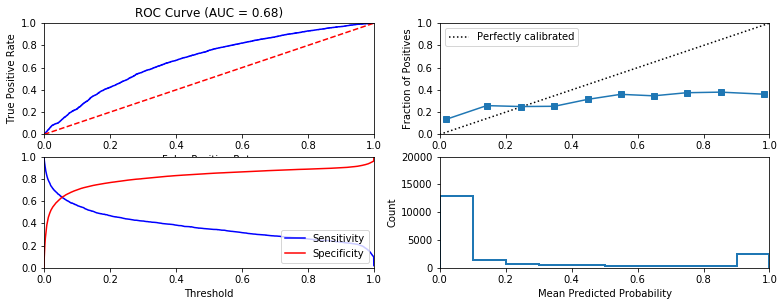


Similarity to LC grade ranking:  0.6912733615235108
Brier score: 0.21629560026682998
Were parameters on edge? : True
Score variations around CV search grid : 48.71155814678001
[0.74896667 0.74543333 0.73453333 0.70303333 0.64933333 0.5752
 0.48573333 0.38413333]


In [37]:
## Train and test a naive bayes classifier
cv_parameters = {'var_smoothing': 10.0 ** -np.arange(2,10)}
gnb = GaussianNB()
gnb = fit_classification(model=gnb,data_dict=data_dict, cv_parameters=cv_parameters,
                         model_name='Naive Bayes', random_state=default_seed)

### $l_1$ regularized logistic regression

  Model: L1 LogReg
Fit time: 5.2 seconds
Optimal parameters:
{'C': 100}

Accuracy-maximizing threshold was: 0.5223279905751382
Accuracy:  0.80305
              precision    recall  f1-score   support

  No default     0.8072    0.9910    0.8897     16032
     Default     0.5457    0.0436    0.0807      3968

   micro avg     0.8031    0.8031    0.8031     20000
   macro avg     0.6765    0.5173    0.4852     20000
weighted avg     0.7553    0.8031    0.7292     20000



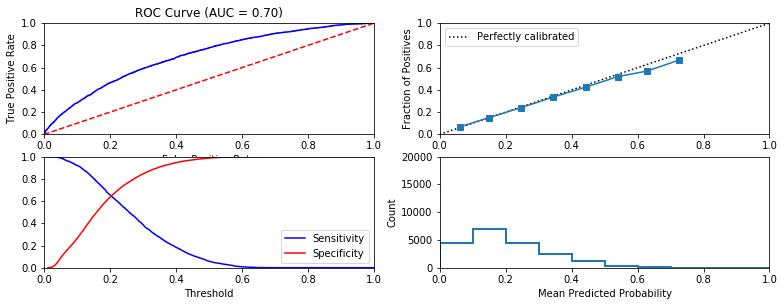


Similarity to LC grade ranking:  0.7473974077573021
Brier score: 0.1455374789461333
Were parameters on edge? : True
Score variations around CV search grid : 0.21647724907371718
[0.7997     0.79896667 0.8001     0.80053333 0.80066667 0.8006
 0.80066667 0.8007    ]


In [65]:
## Train and test a l_1 regularized logistic regression classifier
l1_logistic = LogisticRegression()
cv_parameters = {'C': [0.01,0.1,1,5,10,20,50,100]}

l1_logistic = fit_classification(model=l1_logistic,data_dict=data_dict,
                    cv_parameters=cv_parameters,model_name="L1 LogReg", 
                    random_state=default_seed,output_to_file=True,print_to_screen=True)

### $l_2$ regularized logistic regression

In [45]:
## Train and test a l_2 regularized logistic regression classifier
l2_logistic = RidgeClassifier()

cv_parameters = {'alpha': [i**-1 for i in [0.01,0.1,1,5,10,20,50,100]]}  #alpha corresponds to L1 C**-1
l2_logistic = fit_classification(model=l2_logistic,data_dict=data_dict,
                    cv_parameters=cv_parameters,model_name="L2 LogReg", 
                    random_state=default_seed,output_to_file=True,print_to_screen=True)

  Model: L2 LogReg
Fit time: 0.99 seconds
Optimal parameters:
{'alpha': 0.1}

Accuracy:  0.80345
              precision    recall  f1-score   support

  No default     0.8061    0.9939    0.8902     16032
     Default     0.5801    0.0338    0.0638      3968

   micro avg     0.8034    0.8034    0.8034     20000
   macro avg     0.6931    0.5139    0.4770     20000
weighted avg     0.7612    0.8034    0.7262     20000


Similarity to LC grade ranking:  0.7361659332301513


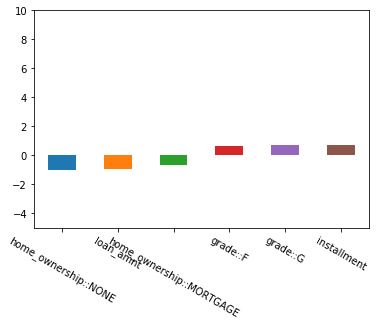

In [22]:
## plot top 3 features with the most positive (and negative) weights 
top_and_bottom_idx = list(np.argsort(l2_logistic['model'].coef_)[0,:3]) + list(np.argsort(l2_logistic['model'].coef_)[0,-3:])
bplot = pd.Series(l2_logistic['model'].coef_[0,top_and_bottom_idx])
xticks = selected_features[top_and_bottom_idx]
p1 = bplot.plot(kind='bar',rot=-30,ylim=(-5,10))
p1.set_xticklabels(xticks)
plt.show()

### Decision tree

  Model: Decision Tree
Fit time: 29.15 seconds
Optimal parameters:
{'max_depth': None, 'min_impurity_decrease': 0.000625}

Accuracy-maximizing threshold was: 1
Accuracy:  0.8016
              precision    recall  f1-score   support

  No default     0.8016    1.0000    0.8899     16032
     Default     0.0000    0.0000    0.0000      3968

   micro avg     0.8016    0.8016    0.8016     20000
   macro avg     0.4008    0.5000    0.4449     20000
weighted avg     0.6426    0.8016    0.7133     20000



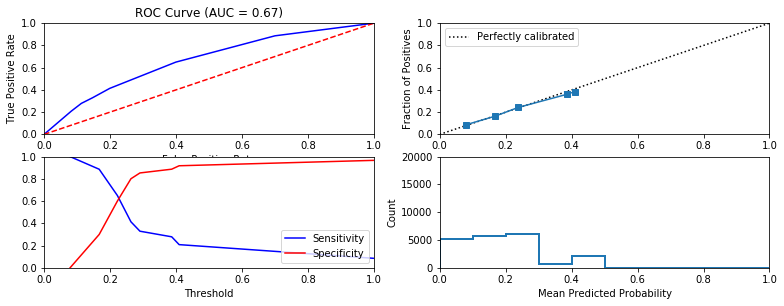


Similarity to LC grade ranking:  0.8312300754044504
Brier score: 0.14993457961569392
Were parameters on edge? : True
Score variations around CV search grid : 12.791327913279126
[0.69723333 0.78006667 0.79443333 0.7967     0.79793333 0.7995
 0.7995     0.7995     0.7995     0.7995     0.7995     0.7995
 0.7995     0.7995     0.7995     0.7995     0.7995     0.7995
 0.7995     0.7995     0.7995     0.7995     0.7995     0.7995
 0.7995     0.7995     0.7995     0.7995     0.7995     0.7995
 0.7995     0.7995     0.7995     0.7995     0.7995     0.7995
 0.79723333 0.79723333 0.79723333 0.79723333 0.7988     0.7995
 0.7995     0.7995     0.7995     0.79666667 0.79686667 0.79613333
 0.79726667 0.79793333 0.7995     0.7995     0.7995     0.7995
 0.79256667 0.79336667 0.79493333 0.7967     0.79793333 0.7995
 0.7995     0.7995     0.7995     0.79203333 0.79426667 0.79453333
 0.7967     0.79793333 0.7995     0.7995     0.7995     0.7995
 0.7864     0.7913     0.79453333 0.7967     0.79793333 0.

In [23]:
## Train and test a decision tree classifier
decision_tree = DecisionTreeClassifier()

maxd = [None]
maxd += range(1,11)

cv_parameters = {'max_depth':maxd, 'min_impurity_decrease':np.linspace(0,0.001,9)}
decision_tree = fit_classification(model=decision_tree,data_dict=data_dict,
                    cv_parameters=cv_parameters,model_name="Decision Tree", 
                    random_state=default_seed,output_to_file=True,print_to_screen=True)

### Random forest

  Model: Random Forest
Fit time: 354.89 seconds
Optimal parameters:
{'criterion': 'gini', 'max_depth': 9, 'min_impurity_decrease': 0.0, 'n_estimators': 50}

Accuracy-maximizing threshold was: 0.3919549611733894
Accuracy:  0.7991
              precision    recall  f1-score   support

  No default     0.8176    0.9645    0.8850     16032
     Default     0.4770    0.1308    0.2053      3968

   micro avg     0.7991    0.7991    0.7991     20000
   macro avg     0.6473    0.5477    0.5452     20000
weighted avg     0.7501    0.7991    0.7502     20000



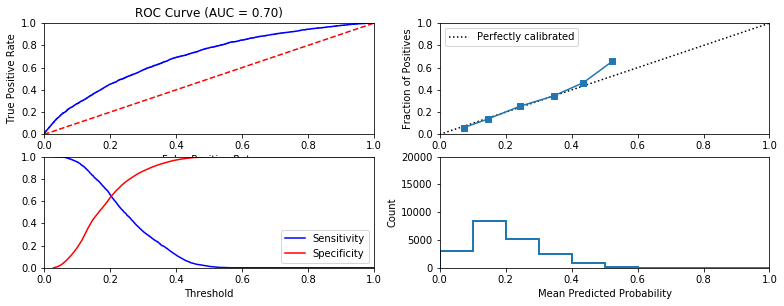


Similarity to LC grade ranking:  0.7624739516645883
Brier score: 0.146433488648312
Were parameters on edge? : True
Score variations around CV search grid : 0.42508856011668583
[0.79643333 0.79966667 0.7995     0.7995     0.7995     0.7995
 0.7995     0.7995     0.7995     0.7995     0.7995     0.7995
 0.7995     0.7995     0.7995     0.7995     0.7995     0.7995
 0.7995     0.7995     0.7995     0.7995     0.7995     0.7995
 0.7995     0.7995     0.7995     0.7995     0.7995     0.7995
 0.7995     0.7995     0.7995     0.7995     0.7995     0.7995
 0.7995     0.7995     0.7995     0.7995     0.7995     0.7995
 0.7995     0.7995     0.7995     0.7995     0.7995     0.7995
 0.7995     0.7995     0.7995     0.7995     0.7995     0.7995
 0.79956667 0.7995     0.7995     0.7995     0.7995     0.7995
 0.7995     0.7995     0.7995     0.79936667 0.7994     0.7995
 0.7995     0.7995     0.7995     0.7995     0.7995     0.7995
 0.7996     0.7997     0.7995     0.7995     0.7995     0.7995
 0.7

In [24]:
## Train and test a random forest classifier

random_forest = RandomForestClassifier()

maxd = [None]
maxd += range(1,11)
cv_parameters = {'n_estimators':[50],'criterion':['gini', 'entropy'], 'max_depth':maxd, 'min_impurity_decrease':np.linspace(0,0.001,9)}

random_forest = fit_classification(model=random_forest,data_dict=data_dict,
                    cv_parameters=cv_parameters,model_name="Random Forest", 
                    random_state=default_seed)

# Fit time: 354.89 seconds
# Optimal parameters:
# {'criterion': 'gini', 'max_depth': 9, 'min_impurity_decrease': 0.0, 'n_estimators': 50}
# ROC AUC = 0.7

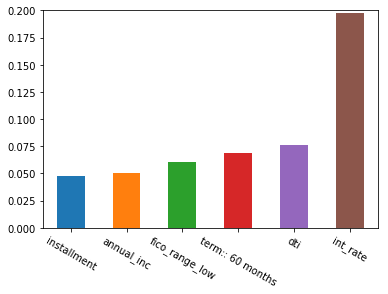

In [25]:
## Plot top 6 most significant features
top_idx = list(np.argsort(random_forest['model'].feature_importances_)[-6:]) 
bplot = pd.Series(random_forest['model'].feature_importances_[top_idx])
xticks = selected_features[top_idx]
p2 = bplot.plot(kind='bar',rot=-30,ylim=(0,0.2))
p2.set_xticklabels(xticks)
plt.show()

### Multi-layer perceptron

In [ ]:
## Train and test a multi-layer perceptron classifier
mlp = MLPClassifier()
cv_parameters = {'hidden_layer_sizes':[x for x in itertools.product((10,20,50),repeat=3)], 
                 'alpha': 10.0 ** -np.arange(2, 6),
                 'activation': ['identity', 'logistic', 'tanh', 'relu']}
mlp = fit_classification(model=mlp,data_dict=data_dict,
                    cv_parameters=cv_parameters,model_name="MLPerceptron", 
                    random_state=default_seed)

## Train and Test logistic regression model with features derived by LendingClub

  Model: lc1_onlyLC_logistic
Fit time: 0.31 seconds
Optimal parameters:
{'C': 0.01}

Accuracy-maximizing threshold was: 1
Accuracy:  0.8016
              precision    recall  f1-score   support

  No default     0.8016    1.0000    0.8899     16032
     Default     0.0000    0.0000    0.0000      3968

   micro avg     0.8016    0.8016    0.8016     20000
   macro avg     0.4008    0.5000    0.4449     20000
weighted avg     0.6426    0.8016    0.7133     20000



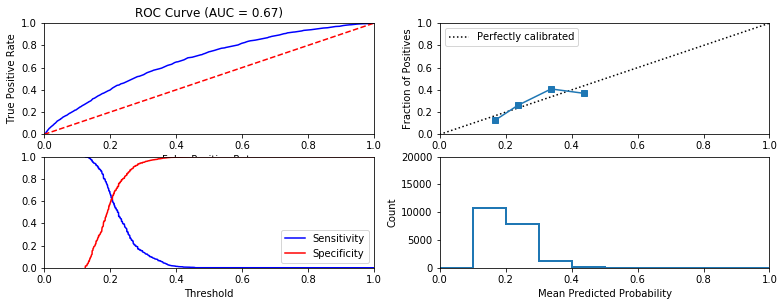


Similarity to LC grade ranking:  0.8603577940356465
Brier score: 0.1517075487793587
Were parameters on edge? : True
Score variations around CV search grid : 0.3418803418803459
[0.7995     0.79736667 0.79686667 0.79676667 0.79676667 0.79676667
 0.79676667 0.79676667]


In [56]:
## Find a lendingClub-defined feature and train a l1-regularized logistic regression model on data with only that feature
a_lendingclub_feature = ['int_rate']

data_dict2 = prepare_data(feature_subset = a_lendingclub_feature)

lc1_onlyLC_logistic = LogisticRegression()
cv_parameters = {'C': [0.01,0.1,1,5,10,20,50,100]}
lc1_onlyLC_logistic = fit_classification(model=lc1_onlyLC_logistic,data_dict=data_dict2,
                    cv_parameters=cv_parameters,model_name="lc1_onlyLC_logistic", 
                    random_state=default_seed,output_to_file=True,print_to_screen=True)

In [57]:
## Train and test a l_2 regularized logistic regression classifier
l2_onlyLC_logistic = RidgeClassifier()

cv_parameters = {'alpha': [i**-1 for i in [0.01,0.1,1,5,10,20,50,100]]}  #alpha corresponds to L1 C**-1
l2_onlyLC_logistic = fit_classification(model=l2_onlyLC_logistic,data_dict=data_dict2,
                    cv_parameters=cv_parameters,model_name="L2 LogReg", 
                    random_state=default_seed,output_to_file=True,print_to_screen=True)

  Model: L2 LogReg
Fit time: 0.13 seconds
Optimal parameters:
{'alpha': 10.0}

Accuracy:  0.79955
              precision    recall  f1-score   support

  No default     0.8025    0.9948    0.8884     16032
     Default     0.3360    0.0106    0.0205      3968

   micro avg     0.7995    0.7995    0.7995     20000
   macro avg     0.5692    0.5027    0.4544     20000
weighted avg     0.7099    0.7995    0.7162     20000


Similarity to LC grade ranking:  0.8603577940356465


## Train and test all the models you have tried previously after removing features derived by LendingClub 

In [31]:
non_lendingClub_features = set(selected_features).difference({'int_rate', 'grade::B', 'grade::C', 'grade::D',
                                                     'grade::E', 'grade::F', 'grade::G', 'grade::nan'})

#
#
#
#
#
#
#
# include these features as well???
# 'verification_status::Source Verified, verification_status::Verified, verification_status::nan'


data_dict3 = prepare_data(feature_subset = non_lendingClub_features)

### Naive Bayes - w/o LendingClub features

  Model: Naive Bayes
Fit time: 0.68 seconds
Optimal parameters:
{'var_smoothing': 0.01}

Accuracy-maximizing threshold was: 0.9999995424100997
Accuracy:  0.80145
              precision    recall  f1-score   support

  No default     0.8016    0.9998    0.8898     16032
     Default     0.0000    0.0000    0.0000      3968

   micro avg     0.8014    0.8014    0.8014     20000
   macro avg     0.4008    0.4999    0.4449     20000
weighted avg     0.6425    0.8014    0.7133     20000



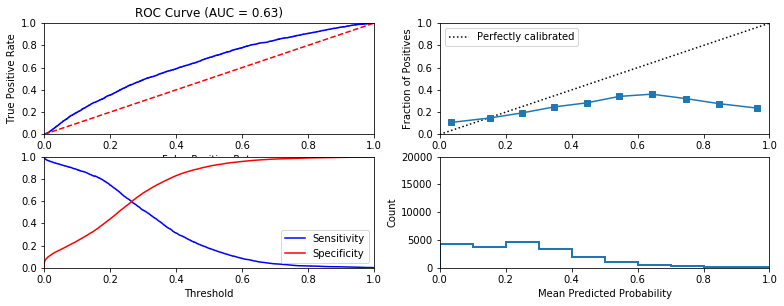


Similarity to LC grade ranking:  0.35399334319563514
Brier score: 0.1718716176339448
Were parameters on edge? : True
Score variations around CV search grid : 0.4250098584761102
[0.76076667 0.75803333 0.75756667 0.75756667 0.75753333 0.75753333
 0.75753333 0.75753333]


In [58]:
## Train and test a naive bayes classifier
cv_parameters = {'var_smoothing': 10.0 ** -np.arange(2,10)}
gnb_noLC = GaussianNB()
gnb_noLC = fit_classification(model=gnb_noLC,data_dict=data_dict3, cv_parameters=cv_parameters,
                         model_name='Naive Bayes', random_state=default_seed)

### $l_1$ regularized logistic regression  - w/o LendingClub features

  Model: L1 LogReg
Fit time: 1.14 seconds
Optimal parameters:
{'C': 0.01}

Accuracy-maximizing threshold was: 0.4416757223083135
Accuracy:  0.8016
              precision    recall  f1-score   support

  No default     0.8016    1.0000    0.8899     16032
     Default     0.0000    0.0000    0.0000      3968

   micro avg     0.8016    0.8016    0.8016     20000
   macro avg     0.4008    0.5000    0.4449     20000
weighted avg     0.6426    0.8016    0.7133     20000



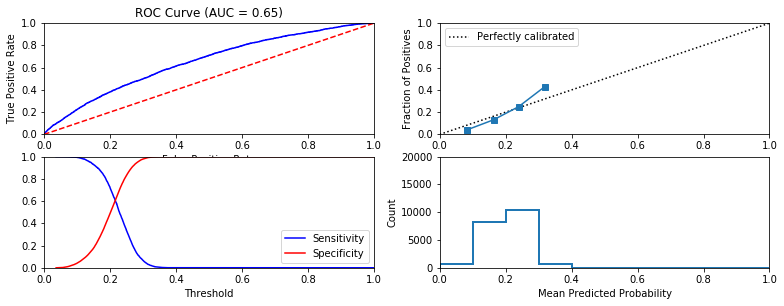


Similarity to LC grade ranking:  0.39619165410869484
Brier score: 0.15294725311534482
Were parameters on edge? : True
Score variations around CV search grid : 0.09589326662497727
[0.7995     0.79913333 0.79893333 0.79873333 0.7988     0.79873333
 0.79873333 0.79873333]


In [59]:
## Train and test a l_1 regularized logistic regression classifier
l1_logistic_noLC = LogisticRegression()
cv_parameters = {'C': [0.01,0.1,1,5,10,20,50,100]}

l1_logistic_noLC = fit_classification(model=l1_logistic_noLC,data_dict=data_dict3,
                    cv_parameters=cv_parameters,model_name="L1 LogReg", 
                    random_state=default_seed,output_to_file=True,print_to_screen=True)

### $l_2$ regularized logistic regression - w/o LendingClub features

In [60]:
## Train and test a l_2 regularized logistic regression classifier
l2_logistic_noLC = RidgeClassifier()

cv_parameters = {'alpha': [i**-1 for i in [0.01,0.1,1,5,10,20,50,100]]}  #alpha corresponds to L1's C**-1
l2_logistic_noLC = fit_classification(model=l2_logistic_noLC,data_dict=data_dict3,
                    cv_parameters=cv_parameters,model_name="L2 LogReg", 
                    random_state=default_seed,output_to_file=True,print_to_screen=True)

  Model: L2 LogReg
Fit time: 0.3 seconds
Optimal parameters:
{'alpha': 100.0}

Accuracy:  0.8016
              precision    recall  f1-score   support

  No default     0.8016    1.0000    0.8899     16032
     Default     0.0000    0.0000    0.0000      3968

   micro avg     0.8016    0.8016    0.8016     20000
   macro avg     0.4008    0.5000    0.4449     20000
weighted avg     0.6426    0.8016    0.7133     20000


Similarity to LC grade ranking:  0.38174370147454384


### Decision tree - w/o LendingClub features

  Model: Decision Tree
Fit time: 17.25 seconds
Optimal parameters:
{'max_depth': None, 'min_impurity_decrease': 0.000375}

Accuracy-maximizing threshold was: 1
Accuracy:  0.8016
              precision    recall  f1-score   support

  No default     0.8016    1.0000    0.8899     16032
     Default     0.0000    0.0000    0.0000      3968

   micro avg     0.8016    0.8016    0.8016     20000
   macro avg     0.4008    0.5000    0.4449     20000
weighted avg     0.6426    0.8016    0.7133     20000



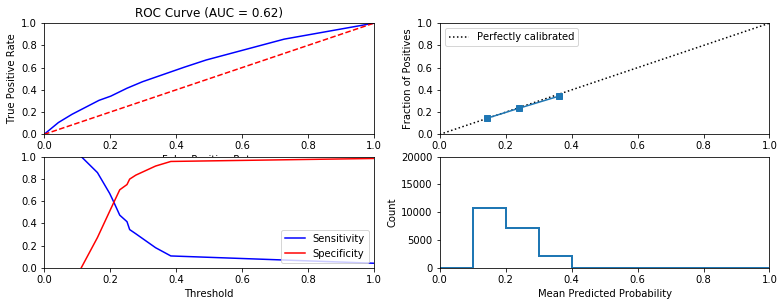


Similarity to LC grade ranking:  0.32886488161295935
Brier score: 0.15404659303817866
Were parameters on edge? : True
Score variations around CV search grid : 13.621013133208256
[0.6906     0.78043333 0.79703333 0.7995     0.7995     0.7995
 0.7995     0.7995     0.7995     0.7995     0.7995     0.7995
 0.7995     0.7995     0.7995     0.7995     0.7995     0.7995
 0.7995     0.7995     0.7995     0.7995     0.7995     0.7995
 0.7995     0.7995     0.7995     0.7995     0.7995     0.7995
 0.7995     0.7995     0.7995     0.7995     0.7995     0.7995
 0.79903333 0.79903333 0.79936667 0.7995     0.7995     0.7995
 0.7995     0.7995     0.7995     0.79683333 0.79676667 0.798
 0.7995     0.7995     0.7995     0.7995     0.7995     0.7995
 0.79593333 0.79596667 0.7978     0.7995     0.7995     0.7995
 0.7995     0.7995     0.7995     0.79076667 0.79156667 0.79726667
 0.7995     0.7995     0.7995     0.7995     0.7995     0.7995
 0.78453333 0.78643333 0.79703333 0.7995     0.7995     0.7995

In [62]:
## Train and test a decision tree classifier
decision_tree_noLC = DecisionTreeClassifier()

maxd = [None]
maxd += range(1,11)

cv_parameters = {'max_depth':maxd, 'min_impurity_decrease':np.linspace(0,0.001,9)}
decision_tree_noLC = fit_classification(model=decision_tree_noLC,data_dict=data_dict3,
                    cv_parameters=cv_parameters,model_name="Decision Tree", 
                    random_state=default_seed,output_to_file=True,print_to_screen=True)

### Random Forest - w/o LendingClub features

  Model: Random Forest
Fit time: 418.08 seconds
Optimal parameters:
{'criterion': 'gini', 'max_depth': 7, 'min_impurity_decrease': 0.0, 'n_estimators': 50}

Accuracy-maximizing threshold was: 0.3639844225523944
Accuracy:  0.7998
              precision    recall  f1-score   support

  No default     0.8060    0.9881    0.8878     16032
     Default     0.4477    0.0388    0.0714      3968

   micro avg     0.7998    0.7998    0.7998     20000
   macro avg     0.6268    0.5135    0.4796     20000
weighted avg     0.7349    0.7998    0.7258     20000



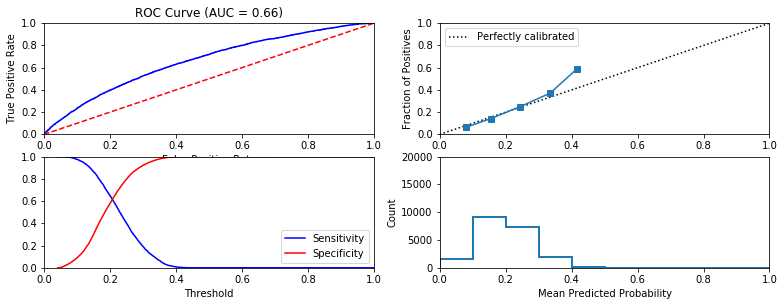


Similarity to LC grade ranking:  0.40915789339736874
Brier score: 0.15123386487159582
Were parameters on edge? : True
Score variations around CV search grid : 0.6003502042858367
[0.79473333 0.79883333 0.7995     0.7995     0.7995     0.7995
 0.7995     0.7995     0.7995     0.7995     0.7995     0.7995
 0.7995     0.7995     0.7995     0.7995     0.7995     0.7995
 0.7995     0.7995     0.7995     0.7995     0.7995     0.7995
 0.7995     0.7995     0.7995     0.7995     0.7995     0.7995
 0.7995     0.7995     0.7995     0.7995     0.7995     0.7995
 0.7995     0.7995     0.7995     0.7995     0.7995     0.7995
 0.7995     0.7995     0.7995     0.7995     0.7995     0.7995
 0.7995     0.7995     0.7995     0.7995     0.7995     0.7995
 0.7995     0.7995     0.7995     0.7995     0.7995     0.7995
 0.7995     0.7995     0.7995     0.79953333 0.7995     0.7995
 0.7995     0.7995     0.7995     0.7995     0.7995     0.7995
 0.79943333 0.79946667 0.7995     0.7995     0.7995     0.7995
 0

In [63]:
## Train and test a random forest classifier

random_forest_noLC = RandomForestClassifier()

maxd = [None]
maxd += range(1,11)
cv_parameters = {'n_estimators':[50],
                 'criterion':['gini', 'entropy'], 
                 'max_depth':maxd, 
                 'min_impurity_decrease':np.linspace(0,0.001,9)}

random_forest_noLC = fit_classification(model=random_forest_noLC,data_dict=data_dict3,
                    cv_parameters=cv_parameters,model_name="Random Forest", 
                    random_state=default_seed)

### Multi-layer perceptron - w/o LendingClub features

In [ ]:
## Train and test a multi-layer perceptron classifier
mlp_noLC = MLPClassifier()
cv_parameters = {'hidden_layer_sizes':[x for x in itertools.product((10,20,50),repeat=3)], 
                 'alpha': 10.0 ** -np.arange(2, 6),
                 'activation': ['identity', 'logistic', 'tanh', 'relu']}
mlp_noLC = fit_classification(model=mlp_noLC, data_dict=data_dict3,
                    cv_parameters=cv_parameters,model_name="MLPerceptron", 
                    random_state=default_seed)

## Time stability test of YOURMODEL
5. Next you will assess the stability of YourModel over time. To this end, analyze whether YourModel trained (using the Random data splitting procedure in part 2. for cross validation) in 2009 performs worse in 2017 than YourModel trained on more recent data in 2016.

  Model: Time stability test: 2016 to 2017
Fit time: 0.05 seconds
Optimal parameters:
{}

Accuracy-maximizing threshold was: 0.4244016655441825
Accuracy:  0.8487142857142858
              precision    recall  f1-score   support

  No default     0.8933    0.9418    0.9169      6206
     Default     0.2101    0.1209    0.1535       794

   micro avg     0.8487    0.8487    0.8487      7000
   macro avg     0.5517    0.5314    0.5352      7000
weighted avg     0.8158    0.8487    0.8303      7000



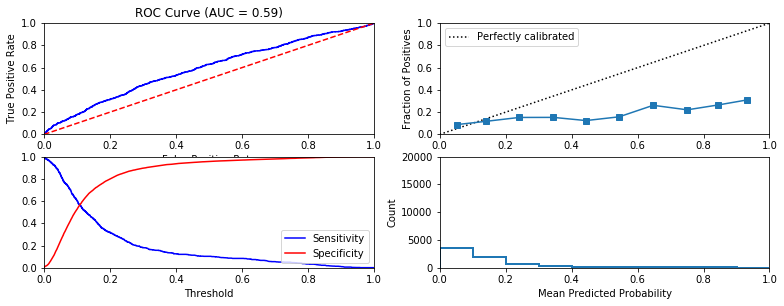


Similarity to LC grade ranking:  0.25725385685022595
Brier score: 0.11642138744865174
Were parameters on edge? : False
Score variations around CV search grid : 0.0
[0.89897959]


{'model': LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
           intercept_scaling=1, max_iter=100, multi_class='warn',
           n_jobs=None, penalty='l2', random_state=None, solver='warn',
           tol=0.0001, verbose=0, warm_start=False),
 'y_pred_labels': array([False, False, False, ..., False, False, False]),
 'y_pred_probs': array([0.09955962, 0.02604236, 0.01611704, ..., 0.19142388, 0.20775178,
        0.28081476])}

In [71]:
##set YOURMODEL
YOURMODEL = l1_logistic['model']


## Define the time window of your train and test data
# Total date range of data: 2010-02-01 to 2017-12-01
#training model using 2010 data

start_date_train = data.issue_d.min()
end_date_train = datetime.date(year = 2010, month = 12, day = 31)

#get predictions for 2017
start_date_test = datetime.date(year = 2017, month = 1, day = 1)
end_date_test = data.issue_d.max()

data_dict_test = prepare_data(date_range_train = (start_date_train, end_date_train), 
                         date_range_test = (start_date_test, end_date_test),
                         n_samples_train = 9000, n_samples_test = 7000, feature_subset = your_features)

## Train and test YOURMODEL using this data

fit_classification(model=YOURMODEL,data_dict=data_dict_test,model_name="Time stability test: 2016 to 2017", 
                    random_state=default_seed,output_to_file=True,print_to_screen=True)

In [70]:
#training model using 2016 data
start_date_train = datetime.date(year = 2016, month = 1, day = 1)
end_date_train = datetime.date(year = 2016, month = 12, day = 31)

data_dict_test = prepare_data(date_range_train = (start_date_train, end_date_train), 
                         date_range_test = (start_date_test, end_date_test),
                         n_samples_train = 9000, n_samples_test = 7000, feature_subset = your_features)

## Train and test YOURMODEL using this data
fit_classification(model=YOURMODEL,data_dict=data_dict_test,model_name="Time stability test: 2016 to 2017", 
                    random_state=default_seed,output_to_file=True,print_to_screen=True)

TypeError: estimator should be an estimator implementing 'fit' method, {'model': LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False), 'y_pred_labels': array([False, False, False, ..., False, False, False]), 'y_pred_probs': array([0.1908432 , 0.13308573, 0.07113714, ..., 0.23852018, 0.36902698,
       0.27868406])} was passed

## Train and test YOURMODEL on the original data

  Model: L1 LogReg
Fit time: 5.64 seconds
Optimal parameters:
{'C': 100}

Accuracy-maximizing threshold was: 0.5223279905751382
Accuracy:  0.80305
              precision    recall  f1-score   support

  No default     0.8072    0.9910    0.8897     16032
     Default     0.5457    0.0436    0.0807      3968

   micro avg     0.8031    0.8031    0.8031     20000
   macro avg     0.6765    0.5173    0.4852     20000
weighted avg     0.7553    0.8031    0.7292     20000



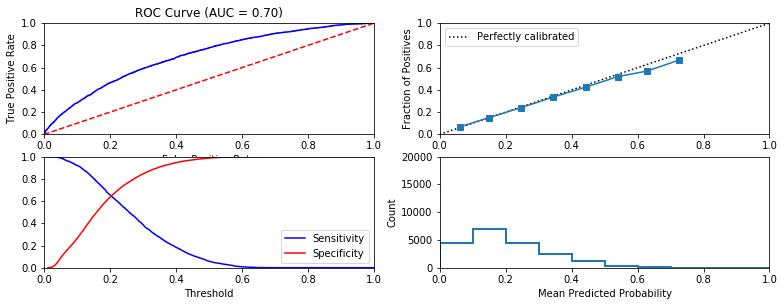


Similarity to LC grade ranking:  0.7473974077573021
Brier score: 0.1455374789461333
Were parameters on edge? : True
Score variations around CV search grid : 0.21647724907371718
[0.7997     0.79896667 0.8001     0.80053333 0.80066667 0.8006
 0.80066667 0.8007    ]


In [69]:
#
#
#
# unsure if we need to train and test the model outside the fit_classification function
# X_train = X[train==True, :]
# X_test = X[train==False, :]
# y_train = y[train==True]
# y_test = y[train==False]
#


## Train and test a l_1 regularized logistic regression classifier
YOURMODEL = fit_classification(model=YOURMODEL,data_dict=data_dict,
                    cv_parameters=cv_parameters,model_name="L1 LogReg", 
                    random_state=default_seed,output_to_file=True,print_to_screen=True)


## Test regression models

In [ ]:
def fit_regression(model, data_dict,
                      cv_parameters = {},
                      separate = False, 
                      model_name = None,
                      random_state = default_seed,
                      output_to_file = True,
                      print_to_screen = True):
    '''
    This function will fit a regression model to data and print various evaluation
    measures. It expects the following parameters
      - model: an sklearn model object
      - data_dict: the dictionary containing both training and testing data;
                   returned by the prepare_data function
      - separate: a Boolean variable indicating whether we fit models for 
                  defaulted and non-defaulted loans separately
      - cv_parameters: a dictionary of parameters that should be optimized
                       over using cross-validation. Specifically, each named
                       entry in the dictionary should correspond to a parameter,
                       and each element should be a list containing the values
                       to optimize over      
      - model_name: the name of the model being fit, for printouts
      - random_state: the random seed to use
      - output_to_file: if the results will be saved to the output file
      - print_to_screen: if the results will be printed on screen
    
    This function returns a dictionary FOR EACH RETURN DEFINITION with the following entries
      - model: the best fitted model
      - predicted_return: prediction result based on the test set
      - predicted_regular_return: prediction result for non-defaulted loans (valid if separate == True)
      - predicted_default_return: prediction result for defaulted loans (valid if separate == True)
      - r2_scores: the testing r2_score(s) for the best fitted model
    '''
    
    np.random.seed(random_state)
    
    # --------------------------
    #   Step 1 - Load the data
    # --------------------------
    
    col_list = ['ret_PESS', 'ret_OPT', 'ret_INTa', 'ret_INTb']
    
    X_train = data_dict['X_train']
    filter_train = data_dict['train_set']  

    X_test = data_dict['X_test']
    filter_test = data_dict['test_set']
    out = {}
    
    for ret_col in col_list:
        
        y_train = data.loc[filter_train, ret_col].as_matrix()
        y_test = data.loc[filter_test, ret_col].as_matrix() 

        # --------------------------
        #   Step 2 - Fit the model
        # --------------------------

        if separate:
            outcome_train = data.loc[filter_train, 'outcome']
            outcome_test = data.loc[filter_test, 'outcome']

            # Train two separate regressors for defaulted and non-defaulted loans
            X_train_0 = X_train[outcome_train == False]
            y_train_0 = y_train[outcome_train == False]
            X_test_0 = X_test[outcome_test == False]
            y_test_0 = y_test[outcome_test == False]

            X_train_1 = X_train[outcome_train == True]
            y_train_1 = y_train[outcome_train == True]
            X_test_1 = X_test[outcome_test == True]
            y_test_1 = y_test[outcome_test == True]

            cv_model_0 = GridSearchCV(model, cv_parameters, scoring='r2')
            cv_model_1 = GridSearchCV(model, cv_parameters, scoring='r2')

            start_time = time.time()
            cv_model_0.fit(X_train_0, y_train_0)
            cv_model_1.fit(X_train_1, y_train_1)
            end_time = time.time()

            best_model_0 = cv_model_0.best_estimator_
            best_model_1 = cv_model_1.best_estimator_
            
            if print_to_screen:

                if model_name != None:
                    print("=========================================================")
                    print("  Model: " + model_name + "  Return column: " + ret_col)
                    print("=========================================================")

                print("Fit time: " + str(round(end_time - start_time, 2)) + " seconds")
                print("Optimal parameters:")
                print("model_0:",cv_model_0.best_params_, "model_1",cv_model_1.best_params_)

            predicted_regular_return = best_model_0.predict(X_test)
            predicted_default_return = best_model_1.predict(X_test)
            
            if print_to_screen:
                print("")
                print("Testing r2 scores:")
            # Here we use different testing set to report the performance
            test_scores = {'model_0':r2_score(y_test_0,best_model_0.predict(X_test_0)),
                              'model_1':r2_score(y_test_1,best_model_1.predict(X_test_1))}
            if print_to_screen:
                print("model_0:", test_scores['model_0'])
                print("model_1:", test_scores['model_1'])

            cv_objects = {'model_0':cv_model_0, 'model_1':cv_model_1}
            out[ret_col] = { 'model_0':best_model_0, 'model_1':best_model_1, 'predicted_regular_return':predicted_regular_return,
                      'predicted_default_return':predicted_default_return,'r2_scores':test_scores }

        else:
            cv_model = GridSearchCV(model, cv_parameters, scoring='r2')

            start_time = time.time()
            cv_model.fit(X_train, y_train)
            end_time = time.time()

            best_model = cv_model.best_estimator_
            
            if print_to_screen:
                if model_name != None:
                    print("=========================================================")
                    print("  Model: " + model_name + "  Return column: " + ret_col)
                    print("=========================================================")

                print("Fit time: " + str(round(end_time - start_time, 2)) + " seconds")
                print("Optimal parameters:")
                print(cv_model.best_params_)

            predicted_return = best_model.predict(X_test)
            test_scores = {'model':r2_score(y_test,predicted_return)}
            if print_to_screen:
                print("")
                print("Testing r2 score:", test_scores['model'])

            cv_objects = {'model':cv_model}
            out[ret_col] = {'model':best_model, 'predicted_return':predicted_return, 'r2_scores':r2_score(y_test,predicted_return)}

        # Output the results to a file
        if output_to_file:
            for i in cv_objects:
                # Check whether any of the CV parameters are on the edge of
                # the search space
                opt_params_on_edge = find_opt_params_on_edge(cv_objects[i])
                dump_to_output(model_name + "::" + ret_col + "::search_on_edge", opt_params_on_edge)
                if print_to_screen:
                    print("Were parameters on edge (" + i + ") : " + str(opt_params_on_edge))

                # Find out how different the scores are for the different values
                # tested for by cross-validation. If they're not too different, then
                # even if the parameters are off the edge of the search grid, we should
                # be ok
                score_variation = find_score_variation(cv_objects[i])
                dump_to_output(model_name + "::" + ret_col + "::score_variation", score_variation)
                if print_to_screen:
                    print("Score variations around CV search grid (" + i + ") : " + str(score_variation))

                # Print out all the scores
                dump_to_output(model_name + "::all_cv_scores", str(cv_objects[i].cv_results_['mean_test_score']))
                if print_to_screen:
                    print("All test scores : " + str(cv_objects[i].cv_results_['mean_test_score']) )

                # Dump the AUC to file
                dump_to_output( model_name + "::" + ret_col + "::r2", test_scores[i] )

    return out

### $l_1$ regularized linear regression

In [ ]:
## First, trying l1 regularized linear regression with hyper-parameters

cv_parameters = ...

reg_lasso = fit_regression(...)

### $l_2$ regularized linear regressor

In [ ]:
## trying l2 regularized linear regression with hyper-parameters

cv_parameters = ...

reg_ridge = fit_regression(...)

### Multi-layer perceptron regressor

In [ ]:
## trying multi-layer perceptron regression with hyper-parameters

cv_parameters = ...

reg_mlp = fit_regression(...)

### Random forest regressor

In [ ]:
## trying random forest regression with hyper-parameters

cv_parameters = ...

reg_rf = fit_regression(...)

## Test investment strategies 
Now we test several investment strategies using the learning models above

In [ ]:
def test_investments(data_dict,
                        classifier = None,
                        regressor = None,
                        strategy = 'Random', 
                        num_loans = 1000,
                        random_state = default_seed,
                        output_to_file = True):
    '''
    This function tests a variety of investment methodologies and their returns. 
    It will run its tests on the loans defined by the test_set element of the data
    dictionary.
    
    It is currently able to test four strategies
      - random: invest in a random set of loans
      - default-based: score each loan by probability of default, and only invest
                 in the "safest" loans (i.e., those with the lowest probabilities
                 of default)
      - return-based: train a single regression model to predict the expected return
                    of loans in the past. Then, for loans we could invest in, simply
                    rank them by their expected returns and invest in that order.
      - default-& return-based: train two regression models to predict the expected return of
                   defaulted loans and non-defaulted loans in the training set. Then,
                   for each potential loan we could invest in, predict the probability
                   the loan will default, its return if it doesn't default and its
                   return if it does. Then, calculate a weighted combination of
                   the latter using the former to find a predicted return. Rank the
                   loans by this expected return, and invest in that order
    
    It expects the following parameters
      - data_dict: the dictionary containing both training and testing data;
                   returned by the prepare_data function
      - classifier: a fitted model object which is returned by the fit_classification function.
      - regressor: a fitted model object which is returned by the fit_regression function.
      - strategy: the name of the strategy; one of the three listed above
      - num_loans: the number of loans to be included in the test portfolio
      - num_samples: the number of random samples used to compute average return ()   
      - random_state: the random seed to use when selecting a subset of rows
      - output_to_file: if the results will be saved to the output file
      
    The function returns a dictionary FOR EACH RETURN DEFINITION with the following entries
      - strategy: the name of the strategy
      - average return: the return of the strategy based on the testing set
      - test data: the updated Dataframe of testing data. Useful in the optimization section
    '''
    
    np.random.seed(random_state)
    
    # Retrieve the rows that were used to train and test  the
    # classification model
    train_set = data_dict['train_set']
    test_set = data_dict['test_set']
    
    col_list = ['ret_PESS', 'ret_OPT', 'ret_INTa', 'ret_INTb']
    
    # Create a dataframe for testing, including the score
    data_test = data.loc[test_set,:]
    out = {}
    
    for ret_col in col_list:    
    
        if strategy == 'Random':
            # Randomize the order of the rows in the datframe
            data_test = data_test.sample(frac = 1).reset_index(drop = True)

            ## Select num_loans to invest in
            pf_test = ...

            ## Find the average return for these loans
            ret_test = ...

            # Return
            out[ret_col] = {'strategy':strategy, 'average return':ret_test}

            # Dump the strategy performance to file
            if output_to_file:
                dump_to_output(strategy + "," + ret_col + "::average return", ret_test )

            continue
        
        elif strategy == 'Return-based':
            
            colname = 'predicted_return_' + ret_col 

            data_test[colname] = regressor[ret_col]['predicted_return']

            # Sort the loans by predicted return
            data_test = data_test.sort_values(by=colname, ascending = False).reset_index(drop = True)

            ## Pick num_loans loans
            pf_test = ...

            ## Find their return
            ret_test = ...

            # Return
            out[ret_col] = {'strategy':strategy, 'average return':ret_test, 'test data':data_test}

            # Dump the strategy performance to file
            if output_to_file:
                dump_to_output(strategy + "," + ret_col + "::average return", ret_test )

            continue
            
        # Get the predicted scores, if the strategy is not Random or just Regression
        try:
            y_pred_score = classifier['y_pred_probs']
        except:
            y_pred_score = classifier['y_pred_score']

        data_test['score'] = y_pred_score


        if strategy == 'Default-based':
            # Sort the test data by the score
            data_test = data_test.sort_values(by='score').reset_index(drop = True)

            ## Select num_loans to invest in
            pf_test = ...

            ## Find the average return for these loans
            ret_test = ...

            # Return
            out[ret_col] = {'strategy':strategy, 'average return':ret_test}

            # Dump the strategy performance to file
            if output_to_file:
                dump_to_output(strategy + "," + ret_col + "::average return", ret_test )

            continue


        elif strategy == 'Default-return-based':

            # Load the predicted returns
            data_test['predicted_regular_return'] = regressor[ret_col]['predicted_regular_return']
            data_test['predicted_default_return'] = regressor[ret_col]['predicted_default_return']

            # Compute expectation
            colname = 'predicted_return_' + ret_col 
            
            data_test[colname] = ( (1-data_test.score)*data_test.predicted_regular_return + 
                                             data_test.score*data_test.predicted_default_return )

            # Sort the loans by predicted return
            data_test = data_test.sort_values(by=colname, ascending = False).reset_index(drop = True)

            ## Pick num_loans loans
            pf_test = ...

            ## Find their return
            ret_test = ...

            # Return
            out[ret_col] = {'strategy':strategy, 'average return':ret_test, 'test data':data_test}

            # Dump the strategy performance to file
            if output_to_file:
                dump_to_output(strategy + "," + ret_col + "::average return", ret_test )

            continue

        else:
            return 'Not a valid strategy'
        
    return out

In [ ]:
## Test investment strategies using the best performing regressor

col_list = ['ret_PESS', 'ret_OPT', 'ret_INTa', 'ret_INTb']
test_strategy = 'Random'

print('strategy:',test_strategy)   
strat_rand = test_investments(...)

for ret_col in col_list:
    print(ret_col + ': ' + str(strat_rand[ret_col]['average return']))

In [ ]:
test_strategy = 'Default-based'

print('strategy:',test_strategy)
strat_def = test_investments(...)

for ret_col in col_list:
    print(ret_col + ': ' + str(strat_def[ret_col]['average return']))

In [ ]:
test_strategy = 'Return-based'

print('strategy:',test_strategy)
strat_ret = test_investments(...)

for ret_col in col_list:
    print(ret_col + ': ' + str(strat_ret[ret_col]['average return']))

In [ ]:
test_strategy = 'Default-return-based'

## For the Default-return-based strategy we need to fit a new regressor with separate = True
cv_parameters = ...

reg_separate = fit_regression(...)

print('strategy:',test_strategy)
strat_defret = test_investments(...)

for ret_col in col_list:
    print(ret_col + ': ' + str(strat_defret[ret_col]['average return']))

## Sensitivity test of portfolio size

In [ ]:
## Test the best-performing data-driven strategy on different portfolio sizes

result_sensitivity = []

## Vary the portfolio size from 1,000 to 10,000
for num_loans in list(range(1000,10000,1000)):

    reg_0 = test_investments(...)
    result_sensitivity.append(reg_0['ret_PESS']['average return'])
    
result_sensitivity = np.array(result_sensitivity) * 100
sns.pointplot(np.array(list(range(1000,10000,1000))),result_sensitivity)
sns.despine()
plt.ylabel('Investment Return (%)',size = 14)
plt.xlabel('Portfolio Size',size = 14)
plt.show()